<a href="https://colab.research.google.com/github/abia200304/IIIT-Hyderabad-Research_works/blob/main/SAE_GRIDLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip -o /content/my_pems_data.zip

Archive:  /content/my_pems_data.zip
  inflating: my_pems_data/pems_station_500011021_flow_04-01-2024_0600_to_04-07-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-08-2024_0600_to_04-14-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-15-2024_0600_to_04-21-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-22-2024_0600_to_04-28-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_04-29-2024_0600_to_05-05-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-06-2024_0600_to_05-12-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-13-2024_0600_to_05-19-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-20-2024_0600_to_05-26-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_05-27-2024_0600_to_06-02-2024_0600.csv  
  inflating: my_pems_data/pems_station_500011021_flow_06-03-2024_0600_to_06-09-2024_0600.csv  
  inflating: m

In [2]:
from glob import glob
import pandas as pd
import numpy as np

file_paths = glob('/content/my_pems_data/*.csv')
all_data = []

for file in file_paths:
    try:
        df = pd.read_csv(file, delimiter='\t')
        df.columns = df.columns.str.strip()
        if 'Flow (Veh/5 Minutes)' in df.columns and 'Truck Flow (Veh/5 Minutes)' in df.columns:
            all_data.append(df[['Flow (Veh/5 Minutes)', 'Truck Flow (Veh/5 Minutes)']])
        else:
            print(f"Skipping {file}: Required columns not found")
    except Exception as e:
        print(f"Error reading {file}: {e}")


In [3]:
combined_df = pd.concat(all_data, ignore_index=True)
print(combined_df.shape)

(22824, 2)


In [4]:
def process_traffic_data(df):

    processed_df = df.copy()

    processed_df = processed_df.rename(columns={
        'Flow (Veh/5 Minutes)': 'total_flow',
        'Truck Flow (Veh/5 Minutes)': 'truck_flow'
    })

    if 'total_flow' not in processed_df.columns or 'truck_flow' not in processed_df.columns:
        print("Error: Renaming of columns failed. Check original column names.")
        return None

    # Calculate Non-Truck Flow = Total Flow - Truck Flow
    processed_df['non_truck_flow'] = processed_df['total_flow'] - processed_df['truck_flow']

    # Handle any negative values
    negative_mask = processed_df['non_truck_flow'] < 0
    if negative_mask.sum() > 0:
        print(f"⚠️ Warning: {negative_mask.sum()} rows have negative non-truck flow values")
        processed_df.loc[negative_mask, 'non_truck_flow'] = 0

    # Add time-based features
    processed_df['time_index'] = range(len(processed_df))

    return processed_df


In [5]:
processed_df = process_traffic_data(combined_df)

In [6]:
display(processed_df)
print(processed_df.shape)

,total_flow,truck_flow,non_truck_flow,time_index
0,21.0,0.0,21.0,0
1,28.0,0.0,28.0,1
2,21.0,1.0,20.0,2
3,18.0,0.0,18.0,3
4,19.0,0.0,19.0,4
...,...,...,...,...
22819,29.0,0.0,29.0,22819
22820,25.0,0.0,25.0,22820
22821,20.0,0.0,20.0,22821
22822,32.0,0.0,32.0,22822


(22824, 4)


In [7]:
column_1_data = processed_df['truck_flow']
column_2_data = processed_df['non_truck_flow']

In [8]:
coloumn_1_data=np.array(column_1_data)
coloumn_2_data=np.array(column_2_data)

In [9]:
column1_data=coloumn_1_data.reshape(-1,1)
column2_data =coloumn_2_data.reshape(-1,1)

In [10]:
data = np.concatenate([ column1_data,column2_data],axis =1)
print(data.shape)

(22824, 2)


In [11]:
from sklearn.preprocessing import MinMaxScaler

scalar=MinMaxScaler((0,1))
scaled_data=scalar.fit_transform(data)

In [12]:
def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), :]
        X.append(a)
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)
time_step = 15
X, Y= create_dataset(scaled_data, time_step)
print(X.shape)
print(Y.shape)

(22809, 15, 2)
(22809, 2)


In [13]:
X_train=X[:int(0.8*len(X))]
y_train = Y[:int(0.8*len(Y))].reshape(-1,2)
X_test = X[int(0.8*len(X)):]
y_test = Y[int(0.8*len(Y)):].reshape(-1,2)

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18247, 15, 2)
(18247, 2)
(4562, 15, 2)
(4562, 2)


In [15]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.layers import LSTM
# import numpy as np
# from keras import regularizers

# # SAE Parameters
# sparsity_level = 0.05       # e.g., target average activation
# lambda_sparse = 0.001       # weight for KL divergence
# encoding_dim = 32           # latent space (bottleneck)
# num_lstm_layers = 2         # Number of stacked LSTM layers
# lstm_units_per_layer = 64   # Units in each LSTM layer before bottleneck

# # Encoder
# input_shape = (15, 2)
# input_tensor = keras.Input(shape=input_shape)


# x = input_tensor
# for i in range(num_lstm_layers - 1):
#     x = layers.LSTM(lstm_units_per_layer, activation='relu',
#                     return_sequences=True,
#                     kernel_regularizer=regularizers.l2(0.1))(x)

# # The last LSTM layer of the encoder outputs a single vector (bottleneck)
# # This is your 'encoded' representation for the SAE
# encoded = layers.LSTM(encoding_dim, activation='relu',
#                       kernel_regularizer=regularizers.l2(0.1))(x) # This will be the bottleneck output

# encoder = keras.Model(inputs=input_tensor, outputs=encoded)

# # Decoder
# encoded_input = keras.Input(shape=(encoding_dim,))

# decoded = layers.RepeatVector(input_shape[0])(encoded_input) # Repeat `encoding_dim` 15 times

# # Stacked LSTM layers in the decoder
# for i in range(num_lstm_layers - 1):
#     decoded = layers.LSTM(lstm_units_per_layer, activation='relu',
#                           return_sequences=True,
#                           kernel_regularizer=regularizers.l2(0.1))(decoded)

# # The last LSTM layer of the decoder, outputs sequences
# # followed by a TimeDistributed Dense layer to get the final feature dimension
# decoded = layers.LSTM(lstm_units_per_layer, activation='relu',
#                       return_sequences=True,
#                       kernel_regularizer=regularizers.l2(0.1))(decoded)

# # Apply a Dense layer to each timestep to get back to the original feature dimension (2)
# decoded_output = layers.TimeDistributed(layers.Dense(input_shape[1], activation='linear'))(decoded)

# decoder = keras.Model(inputs=encoded_input, outputs=decoded_output)

# # Autoencoder: encoder + decoder
# autoencoder_input = keras.Input(shape=input_shape)
# encoded_output = encoder(autoencoder_input)
# decoded_output_model = decoder(encoded_output) # Changed variable name to avoid conflict

# autoencoder = keras.Model(inputs=autoencoder_input, outputs=decoded_output_model)

# # Custom Sparse Loss Function
# def sparse_loss(y_true, y_pred):
#     # y_true here is the input to the autoencoder (X_train), not the target for prediction (y_train)
#     # for the purpose of the sparsity penalty calculation.
#     mse_loss = tf.reduce_mean(keras.losses.MeanSquaredError()(y_true, y_pred))

#     # Calculate hidden layer activations using the encoder on the input data (y_true)
#     hidden = encoder(y_true) # y_true has shape (None, 15, 2) here, matching encoder input

#     # Calculate mean activation across the batch for each hidden unit
#     # Assuming the bottleneck is the last layer of the encoder which outputs (None, encoding_dim)
#     # The sparsity penalty is applied to these encoded outputs.
#     mean_activation = tf.reduce_mean(hidden, axis=0)
#     mean_activation = tf.clip_by_value(mean_activation, 1e-6, 1 - 1e-6) # Clip for numerical stability

#     # Calculate KL Divergence
#     kl_div = tf.reduce_sum(
#         sparsity_level * tf.math.log(sparsity_level / mean_activation) +
#         (1 - sparsity_level) * tf.math.log((1 - sparsity_level) / (1 - mean_activation))
#     )
#     return mse_loss + lambda_sparse * kl_div

# # Compile the model
# autoencoder.compile(optimizer='adam', loss=sparse_loss)

# # Print model summary to see the architecture
# print("Encoder Summary:")
# encoder.summary()
# print("\nDecoder Summary:")
# decoder.summary()
# print("\nAutoencoder Summary:")
# autoencoder.summary()



# # When fitting the autoencoder for reconstruction, the target (y) should be the same as the input (X)
# history = autoencoder.fit(X_train, X_train, # Use X_train as both input and target for reconstruction
#                           epochs=50,
#                           batch_size=32,
#                           validation_split=0.15,
#                           verbose=1) # Set verbose to 0 for less output during training

In [16]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import numpy as np
# from keras import regularizers

# # --------------------------------------------------------------------------
# # 1. Custom GridLSTM Layer (as provided before)
# # --------------------------------------------------------------------------
# class GridLSTM(layers.Layer):
#     """A 2D Grid LSTM layer."""
#     def __init__(self, units, depth, return_sequences=True, **kwargs):
#         super().__init__(**kwargs)
#         self.units = units
#         self.depth = depth
#         self.return_sequences = return_sequences
#         self.time_cells = [layers.LSTMCell(units) for _ in range(depth)]
#         self.state_size = [tf.TensorShape([self.units]), tf.TensorShape([self.units])] * depth
#         self.output_size = units

#     def build(self, input_shape):
#         for i in range(self.depth):
#             # The input to the first cell in the depth dimension is the original input
#             if i == 0:
#                 self.time_cells[i].build(input_shape)
#             else:
#                 # Subsequent cells receive input from the cell below, which has `self.units` features
#                 self.time_cells[i].build(tf.TensorShape((None, self.units)))
#         self.built = True

#     def call(self, inputs, states=None):
#         batch_size = tf.shape(inputs)[0]
#         timesteps = tf.shape(inputs)[1]

#         if states is None:
#             states = self.get_initial_state(inputs)

#         current_states = list(states)
#         outputs_over_time = []

#         for t in range(timesteps):
#             current_input_at_t = inputs[:, t, :]
#             depth_dim_h = tf.zeros((batch_size, self.units), dtype=inputs.dtype)

#             for d in range(self.depth):
#                 time_dim_state = current_states[d]
#                 cell_input = current_input_at_t + depth_dim_h
#                 output, new_state_tuple = self.time_cells[d](cell_input, time_dim_state)
#                 current_states[d] = new_state_tuple
#                 depth_dim_h = output
#                 current_input_at_t = output

#             outputs_over_time.append(depth_dim_h)

#         output_sequence = tf.stack(outputs_over_time, axis=1)

#         if self.return_sequences:
#             return output_sequence
#         return output_sequence[:, -1, :]

#     def get_initial_state(self, inputs):
#         batch_size = tf.shape(inputs)[0]
#         return [cell.get_initial_state(batch_size=batch_size, dtype=inputs.dtype) for cell in self.time_cells]


# # --------------------------------------------------------------------------
# # 2. Model Definition with GridLSTM
# # --------------------------------------------------------------------------

# # SAE & Model Parameters
# sparsity_level = 0.05
# lambda_sparse = 0.001
# encoding_dim = 32
# grid_depth = 2      # Number of layers in the GridLSTM
# grid_units = 64     # Units in each GridLSTM cell

# # Input Shape
# input_shape = (15, 2)
# input_tensor = keras.Input(shape=input_shape)

# # --- Encoder using GridLSTM ---
# # We want the final hidden state of the sequence as the bottleneck.
# # We achieve this by setting return_sequences=False.
# grid_encoder_layer = GridLSTM(units=encoding_dim, depth=grid_depth, return_sequences=False, name="Grid_Encoder")
# encoded = grid_encoder_layer(input_tensor)
# encoder = keras.Model(inputs=input_tensor, outputs=encoded, name="Encoder")

# # --- Decoder using GridLSTM ---
# encoded_input = keras.Input(shape=(encoding_dim,), name="Encoded_Input")
# decoded = layers.RepeatVector(input_shape[0])(encoded_input)

# # The decoder's GridLSTM should return the full sequence.
# grid_decoder_layer = GridLSTM(units=grid_units, depth=grid_depth, return_sequences=True, name="Grid_Decoder")
# decoded = grid_decoder_layer(decoded)

# # Final output layer to match the original feature dimension
# decoded_output = layers.TimeDistributed(layers.Dense(input_shape[1], activation='linear'))(decoded)
# decoder = keras.Model(inputs=encoded_input, outputs=decoded_output, name="Decoder")

# # --- Autoencoder: GridLSTM Encoder + GridLSTM Decoder ---
# autoencoder_input = keras.Input(shape=input_shape, name="Autoencoder_Input")
# encoded_output = encoder(autoencoder_input)
# decoded_output_model = decoder(encoded_output)
# autoencoder = keras.Model(inputs=autoencoder_input, outputs=decoded_output_model, name="Grid_SAE")


# # --------------------------------------------------------------------------
# # 3. Sparse Loss Function (Identical to your original code)
# # --------------------------------------------------------------------------
# def sparse_loss(y_true, y_pred):
#     mse_loss = tf.reduce_mean(keras.losses.MeanSquaredError()(y_true, y_pred))
#     hidden = encoder(y_true)
#     mean_activation = tf.reduce_mean(hidden, axis=0)
#     mean_activation = tf.clip_by_value(mean_activation, 1e-6, 1 - 1e-6)
#     kl_div = tf.reduce_sum(
#         sparsity_level * tf.math.log(sparsity_level / mean_activation) +
#         (1 - sparsity_level) * tf.math.log((1 - sparsity_level) / (1 - mean_activation))
#     )
#     return mse_loss + lambda_sparse * kl_div

# # --------------------------------------------------------------------------
# # 4. Compile and Summarize
# # --------------------------------------------------------------------------
# autoencoder.compile(optimizer='adam', loss=sparse_loss)

# print("Encoder Summary:")
# encoder.summary()
# print("\nDecoder Summary:")
# decoder.summary()
# print("\nAutoencoder Summary:")
# autoencoder.summary()

# # Dummy data for demonstration
# # X_train = np.random.rand(500, 15, 2)

# # history = autoencoder.fit(X_train, X_train,
# #                           epochs=50,
# #                           batch_size=32,
# #                           validation_split=0.15,
# #                           verbose=1)

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from keras import regularizers

# Define GridLSTM layer
class GridLSTM(layers.Layer):
    def __init__(self, units, depth, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.depth = depth
        self.time_cells = [layers.LSTMCell(units) for _ in range(depth)]
        self.input_transform_layer = None

    def build(self, input_shape):
        features = input_shape[-1]
        if features is not None and features != self.units:
            self.input_transform_layer = layers.Dense(self.units)
            self.input_transform_layer.build(tf.TensorShape([None, features]))
        self.built = True

    def call(self, inputs, states=None):
        batch_size = tf.shape(inputs)[0]
        timesteps = tf.shape(inputs)[1]

        if states is None:
            states = [
                (tf.zeros((batch_size, self.units)), tf.zeros((batch_size, self.units)))
                for _ in self.time_cells
            ]

        outputs_over_time = tf.TensorArray(tf.float32, size=timesteps)

        def loop_body(t, current_states_tuple, outputs_ta):
            current_input_t = inputs[:, t, :]

            if self.input_transform_layer is not None:
                current_input_transformed = self.input_transform_layer(current_input_t)
            else:
                current_input_transformed = current_input_t

            current_depth_input = current_input_transformed
            new_states_list = []

            for d in range(self.depth):
                h_state, c_state = current_states_tuple[d]
                cell_input = current_depth_input + h_state
                output, new_state = self.time_cells[d](cell_input, (h_state, c_state))
                new_states_list.append(new_state)
                current_depth_input = output

            outputs_ta = outputs_ta.write(t, current_depth_input)
            return (t + 1, tuple(new_states_list), outputs_ta)

        def loop_cond(t, *_):
            return t < timesteps

        _, _, final_outputs_ta = tf.while_loop(
            loop_cond,
            loop_body,
            loop_vars=(tf.constant(0), states, outputs_over_time)
        )

        sequence = final_outputs_ta.stack()
        sequence = tf.transpose(sequence, perm=[1, 0, 2])  # Shape: (batch, time, units)
        last_output = sequence[:, -1, :]  # Use final timestep output for encoding
        return last_output

#  SAE with GridLSTM
sparsity_level = 0.05
lambda_sparse = 0.001
encoding_dim = 32
grid_depth = 2

# Encoder
input_seq = keras.Input(shape=(15, 2))
encoded_seq = GridLSTM(units=encoding_dim, depth=grid_depth)(input_seq)
encoder_model = keras.Model(inputs=input_seq, outputs=encoded_seq)

# Decoder
encoded_input = keras.Input(shape=(encoding_dim,))
decoded = layers.Dense(30, activation='sigmoid')(encoded_input)
reshaped = layers.Reshape((15, 2))(decoded)
decoder_model = keras.Model(inputs=encoded_input, outputs=reshaped)

# Autoencoder
ae_input = keras.Input(shape=(15, 2))
hidden_repr = encoder_model(ae_input)
reconstructed = decoder_model(hidden_repr)
autoencoder = keras.Model(inputs=ae_input, outputs=reconstructed)

# Custom sparse loss
def sparse_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))
    hidden = encoder_model(y_true)
    mean_activation = tf.reduce_mean(hidden, axis=0)
    mean_activation = tf.clip_by_value(mean_activation, 1e-6, 1 - 1e-6)
    kl_div = tf.reduce_sum(
        sparsity_level * tf.math.log(sparsity_level / mean_activation) +
        (1 - sparsity_level) * tf.math.log((1 - sparsity_level) / (1 - mean_activation))
    )
    return mse + lambda_sparse * kl_div

autoencoder.compile(optimizer='adam', loss=sparse_loss)
autoencoder.summary()


autoencoder.fit(X_train, X_train, epochs=50,validation_split=0.15)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 15, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 32)             │        16,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_2 (Functional)       │ (None, 15, 2)          │           990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,726 (69.24 KB)

 Trainable params: 17,726 (69.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.0487 - val_loss: 0.0167
Epoch 2/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0106 - val_loss: 0.0160
Epoch 3/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.0104 - val_loss: 0.0145
Epoch 4/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.0097 - val_loss: 0.0138
Epoch 5/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0095 - val_loss: 0.0130
Epoch 6/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0093 - val_loss: 0.0122
Epoch 7/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.0088 - val_loss: 0.0115
Epoch 8/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.0085 - val_loss: 0.0113
Epoch 9/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0081 - val_loss: 0.0112
Epoch 10/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0081 - val_loss: 0.0107
Epoch 11/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.0081 - val_loss: 0.0100
Epoch 12/50
485/485 ━━━━━━━━━━

In [19]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
y_pred=autoencoder.predict(X_test)
test_predict=autoencoder.predict(X_test)
print(test_predict.shape)

predictions_original_scale = scalar.inverse_transform(test_predict[:, -1, :])
y_test_original_scale = scalar.inverse_transform(y_test)
mae=mean_absolute_error(predictions_original_scale,y_test_original_scale,)
mse=np.sqrt(mean_squared_error(predictions_original_scale,y_test_original_scale,))

epsilon = 1e-10
mape=mean_absolute_percentage_error(predictions_original_scale,y_test_original_scale)

rmse=np.sqrt(mse)
print(f"RMSE: {rmse}")

print(f"MAE: {mae}")
print(f"MAPE: {mape}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(4562, 15, 2)
RMSE: 4.016095695724692
MAE: 8.105432208232232
MAPE: 0.4591780035304889


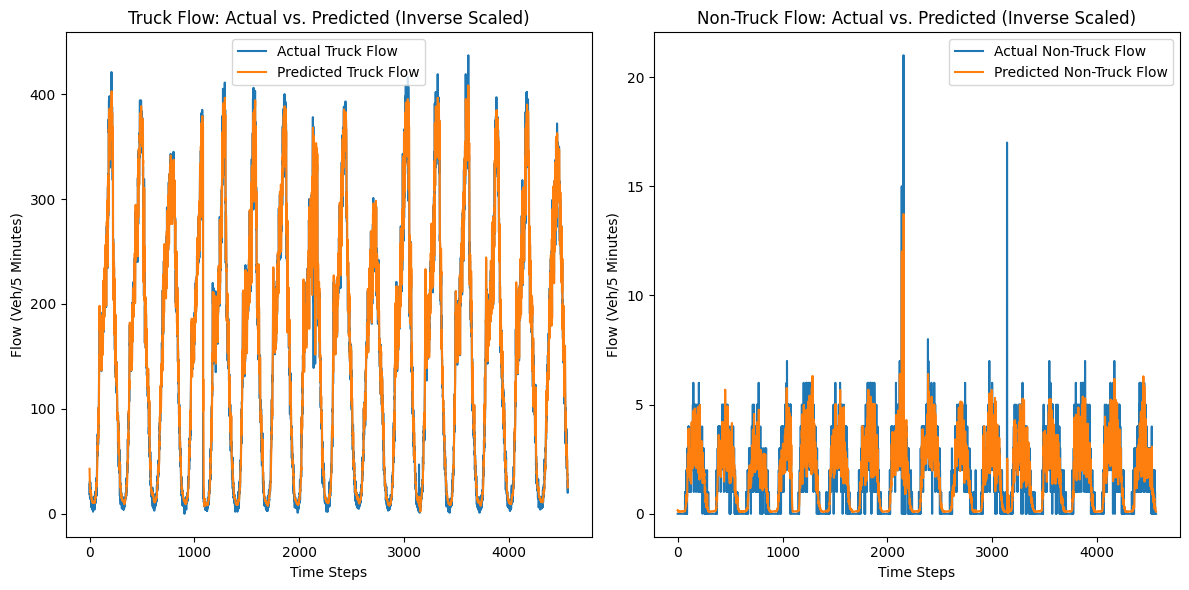

In [20]:

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

#  Truck Flow
plt.subplot(1, 2, 1)
plt.plot(y_test_original_scale[:, 1], label='Actual Truck Flow')
plt.plot(predictions_original_scale[:, 1], label='Predicted Truck Flow')
plt.title('Truck Flow: Actual vs. Predicted (Inverse Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Flow (Veh/5 Minutes)')
plt.legend()

# Non-Truck Flow
plt.subplot(1, 2, 2)
plt.plot(y_test_original_scale[:, 0] , label='Actual Non-Truck Flow')
plt.plot(predictions_original_scale[:, 0], label='Predicted Non-Truck Flow')
plt.title('Non-Truck Flow: Actual vs. Predicted (Inverse Scaled)')
plt.xlabel('Time Steps')
plt.ylabel('Flow (Veh/5 Minutes)')
plt.legend()

plt.tight_layout()
plt.show()